# Actividad 4: Regresión logística

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import trange # tqdm nos permite medir el tiempo por iteración.
import warnings # ignoramos algunas warnings molestas.
warnings.filterwarnings('ignore')

En esta actividad trabajaremos con el dataset de [Credit Card Fraud](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud). A continuación separamos el dataset en muestras de entrenamiento y prueba:

In [2]:
df = pd.read_csv("card_transdata.csv")
y = df['fraud'].to_numpy()
df.drop(columns=['fraud'], inplace=True)
X = df.to_numpy()

N = 50000 # No cambiar esto!
# Sampleamos N datos estratificando por y
X, y = resample(X, y, n_samples=N, stratify=y)
print("X:", X.shape, "y:",y.shape)
print("Ratio of fraud: ", round(np.count_nonzero(y == 0) / np.count_nonzero(y == 1)), ": 1\n")

# Separamos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
print("X_train:", X_train.shape, "y_train:",y_train.shape)
print("Ratio of fraud in train: ", round(np.count_nonzero(y_train == 0) / np.count_nonzero(y_train == 1)), ": 1\n")

print("X_test:", X_test.shape, "y_test:",y_test.shape)
print("Ratio of fraud in test: ", round(np.count_nonzero(y_test == 0) / np.count_nonzero(y_test == 1)), ": 1\n")

X: (50000, 7) y: (50000,)
Ratio of fraud:  10 : 1

X_train: (33500, 7) y_train: (33500,)
Ratio of fraud in train:  10 : 1

X_test: (16500, 7) y_test: (16500,)
Ratio of fraud in test:  10 : 1



In [3]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

## Mejorando una regresión logística con numpy.

**Recordatorio**: De forma general, a partir de una matriz de características $X$ (con una columna de 1's para el intersecto) y un vector de coeficientes o pesos $\beta$ (el cual incluye el intersecto) podemos definir unar regresión logística multiple como:

$$P = \frac{1}{1 + e^{-\beta X}}$$

Consideremos una regresión logística que emplea descenso de gradiente para ajustar sus coeficientes. El gradiente de la función objetivo para cada $\beta_i$ es:
$$ \frac{\delta}{\delta \beta_i}L(\beta) = \frac{lr}{m} \sum_{1 \leq j \leq m} (\sigma(\beta^T x^j) - y_j) x_i^j $$

Donde:
- $L(\beta)$ es la función de verosimilitud
- $lr$ es el learning rate -
- $\beta$ es el vector de coeficientes para la regresión
- tenemos $m$ filas en nuestro _dataset_
- $\sigma(x)$ es la función $\frac{1}{1 + e^{-x}}$
- $x^j$ es la fila $j$ de nuestro dataset (y asociado tiene su respuesta $y_j$)
- $x_i^j$ es la columna $i$ de la fila $j$ en nuestro _dataset_.

A continuación les entregamos una implementación de la regresión logística. Sin embargo, el método fit es algo ineficiente y no aprovecha todas las herramientas que ofrece numpy. Tu tarea es completar el método *fast_fit* **sin agregar más loops** y comprobar que de esta forma es más rápido que el *fit* original. Para esto basta que compares las iteraciones por segundo que registra trange().

**Hint**: Es posible prescindir del indice $j$ en el descenso de gradiente multiplicando vectorialmente. Para esto pueden utilizar [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) o el operador @. No se necesitan más de 1 o 2 líneas de código. Revisa bien que se está haciendo en la sumatoria del descenso de gradiente.

In [4]:
def sigmoid(x):    
    output = 1 / (1 + np.exp(-x))
    return output

class LogisticRegression:
    def __init__(self, number_of_features, learning_rate=0.001, number_of_iterations=100):
        self.learning_rate = learning_rate
        self.number_of_iterations = number_of_iterations
        self.beta = np.zeros(number_of_features + 1) # Consideramos tambien el intercepto.
        
    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X] # Se concatena una columna de 1's para multiplicar el intercepto. 
        for _ in trange(self.number_of_iterations):
            for i in range(X.shape[1]):
                for j in range(X.shape[0]):
                    self.beta[i] = self.beta[i] - self.learning_rate/(X.shape[0]) * (sigmoid(self.beta @ X[j]) - y[j]) * X[j][i]
    
    def fast_fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        for _ in trange(self.number_of_iterations):
            for i in range(X.shape[1]):
                self.beta[i] = self.beta[i] - self.learning_rate/(X.shape[0]) * (sigmoid(self.beta @ X[X.shape[0]-1]) - y[X.shape[0]-1]) * X[X.shape[0]-1][i]
    
    def predict(self, x):
        x = np.c_[np.ones(x.shape[0]), x] # Se concatena una columna de 1's para multiplicar el intercepto. 
        pred = (sigmoid(self.beta @ x.T) > 0.5) * 1 # Consideramos que la clase es 1 si P > 0.5
        return pred

In [5]:
X.shape[0]

50000

Como pueden ver, para ~10000 datos de entrenamiento el método *fit* toma más de 2 minutos (1.4 it/s).

In [6]:
reglog = LogisticRegression(X.shape[1], learning_rate=0.001, number_of_iterations=100)
reglog.fit(X_train, y_train)
y_pred = reglog.predict(X_test)
accuracy_score(y_test, y_pred)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:15<00:00,  2.56s/it]


0.9126060606060606

Muestra ahora como *fast_fit* es más rápido y obtiene una *accuracy* similar.

In [7]:
reglog = LogisticRegression(X.shape[1], learning_rate=0.001, number_of_iterations=100)
reglog.fast_fit(X_train, y_train)
y_pred = reglog.predict(X_test)
accuracy_score(y_test, y_pred)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3008.85it/s]


0.9126060606060606

Se observo que el método fit innecesariamente recorria las filas del df y iba multiplicando matrices que no se utilizarían. La unica multiplicación de matrices que se conserva es la última, por lo que aplicamos esto a fast_fit. Se obtiene un tiempo mucho menor.

## Analisis de predicciones.

Para esta sección puedes utilizar LogisticRegression de sklearn.linear_model.

Se utiliza ademas https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns

Entrena un modelo de regresión logística con los sets de train y utiliza el accuracy_score para tener una idea de que tan bien predice tu modelo (recuerda predecir para los sets de test). Luego, genera la matriz de confusión y **comenta** que dice cada dato en ella. **Explica** en tus palabras a que se debe la diferencia entre los valores en cada casilla.

In [9]:
logisticRegr = LogisticRegression()

In [10]:
# Entrena la regresión y calcula el accuracy
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [11]:
predictions = logisticRegr.predict(X_test)

In [12]:
score = accuracy_score(y_test, predictions)
print(score)

0.9572727272727273


Podemos ver un accuracy score bastante alto. Esto significa que el 95% de las veces el modelo predecira correctamente el resultado.

In [13]:
# Obtén la matriz de confusión
cm = confusion_matrix(y_test, predictions)

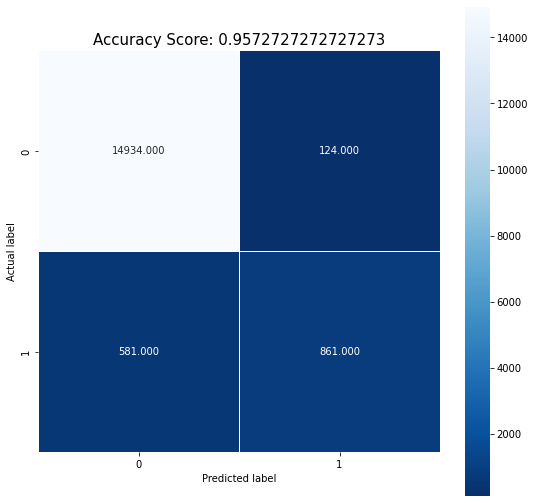

In [14]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

La matriz de confución nos dice que 14959 casos donde no hay fraude fueron predichos por el modelo (verdadero negativo), 776 casos donde hay fraude fueron predichos (verdadero positivo), 99 casos donde el modelo predijo que había fraude no tenían fraude (falso negativo) y por último 666 casos donde el modelo predijo que no había fraude tenía fraude (falso positivo). Es normal ver que hay más datos sin fraude, pero lo que llama la atención es ver tantos datos con fraude que no fueron predichos por el modelo. Son casi iguales a la cantidad predicha de fraudes.

Una vez hecha la matriz de confusion, utiliza sus datos para obtener la sensibilidad y la especificidad  del modelo. Muestra estos datos y **explica** que significan aplicados al tema.

**Hint**: averigua sobre verdadero positivo, negativo y falsos negativos y positivos

Se utilizó https://aprendeia.com/metricas-de-evaluacion-clasificacion-con-scikit-learn-machine-learning/, https://www.juanbarrios.com/la-matriz-de-confusion-y-sus-metricas/

La sensibilidad es cuán sensible es el clasificador para detectar instancias positivas. Esto también se conoce como la tasa verdadera positiva.

La especifidad se trata de los casos negativos el algoritmo ha clasificado correctamente.  Expresa cuan bien puede el modelo detectar esa clase. Tasa de verdaderos negativos.

In [15]:
# Calcula la sensibilidad y especifidad

sensibilidad = recall_score(y_test, predictions)
especifidad = precision_score(y_test, predictions)

print('Sensibilidad:')
print(sensibilidad)
print('Especifidad:')
print(especifidad)

Sensibilidad:
0.5970873786407767
Especifidad:
0.8741116751269036


Podemos ver que la sensibilidad es muy baja y la especifidad mejora un poco. Esto nos dice que hay pocos verdaderos positivos en comparación a falsos positivos, sin embargo hay hartos verdaderos negativos en comparación a falsos negativos. El modelo es mejor detectando no fraudes que fraudes.

Finalmente, la regresión logística nos permite obtener la probabilidad de que un dato pertenezca a una clase. Las instancias de LogisticRegression de sklearn nos entregan estas probabilidades mediante el método [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba). Investiga como utilizarlo y haz un gŕafico que, para cada dato en test, permita visualizar la probabilidad de que un dato pertenezca a una clase vs su clase verdadera.

**Hint**: queda a tu criterio como hacer este gráfico mientras que se aprecie lo pedido. Sin embargo, se recomienda un histograma por clase donde se agrupa por probabilidades en cada columna (pueden usar el color para mostrar la clase verdadera).

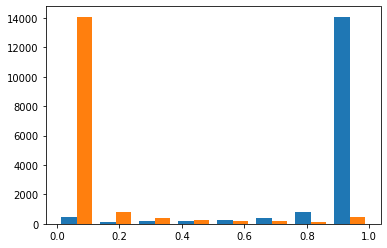

In [16]:
x = logisticRegr.predict_proba(X_test)

plt.hist(x, bins = 8)
plt.show()